In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Grid:
    def __init__(self, rows, cols, start):
        self.rows = rows
        self.cols = cols
        self.i = start[0]
        self.j = start[1]
    
    def set(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions
        
    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]
    
    def current_state(self):
        return (self.i, self.j)
    
    def is_terminal(self, s):
        return s not in self.actions
    
    def get_next_state(self, s, a):
        i, j = s[0], s[1]
        if a in self.actions[(i,j)]:
            if a == 'U':
                i -= 1
            elif a == 'D':
                i += 1
            elif a == 'R':
                j += 1
            elif a == 'L':
                j -= 1
        return i, j
    
    def move(self, action):
        if action in self.actions[(self.i,self.j)]:
            if action == 'U':
                self.i -= 1
            elif action == 'D':
                self.i += 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1
        return self.rewards.get((self.i, self.j), 0)
    
    def undo_move(self, action):
        if action == 'U':
            self.i += 1
        elif action == 'D':
            self.i -= 1
        elif action == 'R':
            self.j -= 1
        elif action == 'L':
            self.j += 1
        assert(self.current_state() in self.all_states())
        
    def game_over(self):
        return (self.i, self.j) not in self.actions
    
    def all_states(self):
        return set(self.actions.keys()) | set(self.rewards.keys())

In [4]:
def standard_grid():
    g = Grid(3,4,(2,0))
    rewards = {
        (0,3):1,
        (1,3):-1
    }
    actions = {
        (0,0): ('D', 'R'),
        (0,1): ('L', 'R'),
        (0,2): ('L', 'D', 'R'),
        (1,0): ('U', 'D'),
        (1,2): ('U', 'D', 'R'),
        (2,0): ('U', 'R'),
        (2,1): ('L', 'R'),
        (2,2): ('L', 'U', 'R'),
        (2,3): ('L', 'U')
    }
    g.set(rewards, actions)
    return g

In [5]:
GAMMA = 0.9
ACTION_SPACE = ('U', 'D', 'L', 'R')

In [6]:
def print_values(V, g):
    for i in range(g.rows):
        print("---------------------------------")
        for j in range(g.cols):
            v = V.get((i,j),0)
            if v >= 0:
                print(" %.2f|"%v, end="")
            else:
                print("%.2f|"%v, end="")
        print("")
        
def print_policy(P, g):
    for i in range(g.rows):
        print("----------------------------------")
        for j in range(g.cols):
            a = P.get((i,j), ' ')
            print("  %s  |"% a, end="")
        print("")

In [7]:
def max_dict(d):
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

In [8]:
def random_action(a, eps=0.1):
    p = np.random.random()
    if p < (1-eps):
        return a
    else:
        return np.random.choice(ACTION_SPACE)

In [9]:
def play_game(grid, policy):
    s = (2,0)
    grid.set_state(s)
    a = random_action(policy[s])
    states_actions_rewards = [(s,a,0)]
    while True:
        r = grid.move(a)
        s = grid.current_state()
        if grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = random_action(policy[s])
            states_actions_rewards.append((s,a,r))
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r+GAMMA*G
    states_actions_returns.reverse()
    return states_actions_returns

rewards:
---------------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------------
 0.00| 0.00| 0.00| 0.00|
0
1000
2000
3000
4000


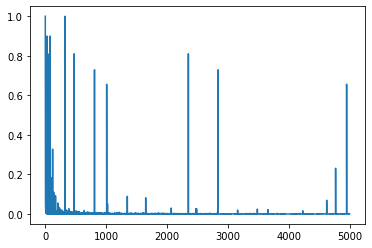

final values
---------------------------------
 0.79| 0.89| 1.00| 0.00|
---------------------------------
 0.70| 0.00| 0.89| 0.00|
---------------------------------
 0.63| 0.67| 0.76| 0.70|
final policy
----------------------------------
  R  |  R  |  R  |     |
----------------------------------
  U  |     |  U  |     |
----------------------------------
  U  |  R  |  U  |  L  |


In [11]:
grid = standard_grid()
print("rewards:")
print_values(grid.rewards, grid)
policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ACTION_SPACE)
    
Q = {}
returns = {}
states = grid.all_states()
for s in states:
    if s in grid.actions:
        Q[s] = {}
        for a in ACTION_SPACE:
            Q[s][a] = 0
            returns[(s,a)] = []
    else:
        pass
deltas = []
for t in range(5000):
    if t % 1000 == 0:
        print(t)
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        sa = (s,a)
        if sa not in seen_state_action_pairs:
            old_q = Q[s][a]
            returns[sa].append(G)
            Q[s][a] = np.mean(returns[sa])
            biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
            seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)
    
    for s in policy.keys():
        a, _ = max_dict(Q[s])
        policy[s] = a
    
plt.plot(deltas)
plt.show()
    
V = {}
for s in policy.keys():
    V[s] = max_dict(Q[s])[1]
        
print("final values")
print_values(V, grid)
print("final policy")
print_policy(policy, grid)
    